<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第5章：在无标签数据上预训练

In [3]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.4
numpy version: 1.26.3
tiktoken version: 0.9.0
torch version: 2.7.1+cu118
tensorflow version: 2.19.0


- 在本章中，我们实现用于预训练LLM的训练循环和基本模型评估代码。
- 在本章的最后，我们还将从OpenAI加载公开可用的预训练权重到我们的模型中。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/chapter-overview.webp" width=500px>

- 本章涵盖的主题如下所示

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## 5.1 评估生成性文本模型

- 本节我们从上一章的代码开始，简要回顾如何初始化一个GPT模型。
- 然后，我们讨论LLM的基本评估指标。
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集。

### 5.1.1 使用GPT生成文本

- 我们使用上一章的代码初始化一个GPT模型

In [4]:
import torch
from previous_chapters import GPTModel
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- 我们在上面使用了0.1的dropout，但现在通常在训练LLM时不使用dropout。
- 现代LLM在`nn.Linear`层中也不使用查询、键和值矩阵的偏置向量（与早期的GPT模型不同），这是通过设置`"qkv_bias": False`来实现的。
- 我们将上下文长度（`context_length`）从256个标记减少到减少计算资源需求，以便训练模型。而原始的1.24亿参数的GPT-2模型使用了1024个标记。 
  - 这样可以使更多读者能够在笔记本电脑上跟随并执行代码示例。
  - 然而，请随意将`context_length`增加到1024个标记（这不需要任何代码更改）。
  - 我们稍后也会从预训练权重中加载一个`context_length`为1024的模型。

- 接下来，我们使用上一章的 `generate_text_simple` 函数来生成文本。
- 此外，我们定义了两个便捷函数，`text_to_token_ids`和`token_ids_to_text`，用于在本章中进行标记和文本表示之间的转换。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-process.webp" width=500px>

In [5]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所示，模型尚未生成良好的文本，因为它还没有经过训练。
- 我们如何以数值形式衡量或捕捉“良好的文本”，以便在训练过程中跟踪它？
- 下一小节将介绍一些度量指标，用于计算生成输出的损失指标，我们可以通过这些指标来衡量训练进度。
- 后续章节关于微调LLM的内容还将介绍其他衡量模型质量的方法。

<br>

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个`inputs`张量，其中包含2个训练样本（行）的标记ID。
- 对应于`inputs`，`targets`包含我们希望模型生成的所需的标记ID。
- 请注意，`targets`是`inputs`向右移动1个位置的结果，正如第2章实现数据加载器时所解释的那样。

In [6]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- 将`inputs`输入到模型中，我们获得包含2个输入样本（每个样本有3个标记）的logits向量。
- 每个标记是一个50,257维的向量，对应于词汇表的大小。
- 应用softmax函数，我们可以将logits张量转换为一个具有相同维度的概率分数张量。

In [7]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 下图中，为了说明目的使用了一个非常小的词汇表，展示了如何将概率分数转换回文本，这是我们上一章最后讨论的内容。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 如上一章所述，我们可以应用`argmax`函数将概率分数转换为预测的标记ID。
- 上面的softmax函数为每个标记生成了一个50,257维的向量；`argmax`函数返回该向量中最高概率分数的位置，即给定标记的预测标记ID。

- 由于我们有2个输入批次，每个批次包含3个标记，因此我们获得2 by 3预测标记ID：

In [8]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些标记，我们会发现这些标记与我们希望模型预测的标记（即目标标记）有很大的不同：

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型还没有经过训练。
- 为了训练模型，我们需要知道模型预测的结果与正确的目标有多远。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 对应于目标索引的标记概率如下：

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化这些值，使其接近概率为1
- 在数学优化中，最大化概率分数的对数比直接最大化概率分数更容易；这超出了本书的范围，但我在此处录制了一节讲座以更多细节： [L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [11]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：

In [12]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是通过优化模型权重来使这个平均对数概率尽可能大。
- 由于对数函数的存在，最大的可能值是0，而我们目前离0还很远。

- 在深度学习中，我们通过最小化负的平均对数概率值来代替最大化平均对数概率。在我们的情况下，深度学习中会最小化10.7722（即-10.7722的负值），使其接近0。
- 负的-10.7722，即10.7722，在深度学习中也称为交叉熵损失。

In [13]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- PyTorch已经实现了一个`cross_entropy`函数，该函数执行了前面的步骤。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp?123" width=400px>

- 在应用`cross_entropy`函数之前，我们先检查logits和targets的形状。

In [14]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的`cross_entropy`函数，我们希望将这些张量展平，通过在批次维度上进行组合。

In [15]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 请注意，目标是标记ID，这些标记ID也表示logits张量中我们希望最大化的索引位置。
- PyTorch中的`cross_entropy`函数会自动在logits中对这些需要最大化的标记索引应用softmax和对数概率计算。

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 与交叉熵损失相关的一个概念是LLM的困惑度。
- 困惑度仅仅是交叉熵损失的指数。

In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 困惑度通常被认为更具可解释性，因为它可以理解为模型在每一步不确定的有效词汇表大小（在上面的例子中，这将是48,725个单词或标记）。
- 换句话说，困惑度提供了一种衡量模型预测的概率分布与数据集中实际单词分布匹配程度的方法。
- 类似于损失，较低的困惑度表示模型预测更接近实际分布。

### 5.1.3 计算训练集和验证集的损失

- 我们使用一个相对较小的数据集来训练LLM（实际上只有一个短故事）。
- 原因如下：
  - 你可以在没有合适的GPU的情况下，仅使用笔记本电脑几分钟内运行代码示例。
  - 训练过程相对较快（几分钟而不是几周），这对于教学目的非常好。
  - 我们使用的是公共领域的文本，可以在不违反任何使用权或增加仓库大小的情况下包含在GitHub仓库中。

- 例如，Llama 2 7B在2万亿个标记上训练需要184,320个A100 GPU小时。
  - 在撰写本文时，AWS上8xA100云服务器的每小时费用约为30美元。
  - 因此，通过粗略计算，训练这个LLM的费用约为184,320 / 8 * 30 = 690,000美元。

- 下面，我们使用与第2章中相同的数据集。

In [18]:
import os
import ssl
import urllib.request
import urllib.error

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# 创建一个 SSLContext，可根据需要调整参数
ctx = ssl.create_default_context()
# 例如，禁用 session tickets（可选）
# ctx.options |= ssl.OP_NO_TICKET

def fetch_text(url, context):
    try:
        with urllib.request.urlopen(url, context=context) as resp:
            return resp.read().decode('utf-8')
    except ssl.SSLZeroReturnError:
        # 对端优雅关闭，返回空内容或可重试
        print("警告：SSL 连接已被对端关闭，返回空字符串。")
        return ""
    except urllib.error.URLError as e:
        print(f"网络错误：{e}")
        return ""

if not os.path.exists(file_path):
    text_data = fetch_text(url, ctx)
    # 如果你希望在遇到空内容时重试，可以在这里加个循环或递归
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as f:
        text_data = f.read()

- 通过打印前99个和后99个字符来快速检查文本是否加载正确。

In [19]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [20]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [21]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 由于只有5,145个标记，这段文本对于训练LLM来说非常短，但再次强调，这是为了教学目的（稍后我们还会加载预训练权重）。

- 接下来，我们将数据集分为训练集和验证集，并使用第2章中的数据加载器为LLM训练准备批次。
- 为了可视化目的，下图假设`max_length=6`，但对于训练加载器，我们将`max_length`设置为LLM支持的上下文长度。
- 下图仅为了简化展示了输入标记。
    - 由于我们训练LLM以预测文本中的下一个单词，目标标记与这些输入标记相同，只是目标标记向右移动了一位。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [22]:
from previous_chapters import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [23]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 我们使用相对较小的批次大小来减少计算资源的需求，并且因为数据集本身非常小。
- 例如，Llama 2 7B使用了1024的批次大小进行训练。

- 一个可选的检查，确保数据加载正确：

In [24]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选的检查，确保标记大小符合预期：

In [25]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用函数来计算给定批次的交叉熵损失。
- 此外，我们实现第二个实用函数来计算数据加载器中指定数量批次的损失。

In [26]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果你的机器上有一块支持CUDA的GPU，LLM将在GPU上进行训练，而无需对代码进行任何更改。
- 通过`device`设置，我们确保数据加载到与LLM模型相同的设备上。

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.98110580444336


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 训练LLM

- 在本节中，我们最终实现用于训练LLM的代码
- 我们专注于一个简单的训练函数（如果你有兴趣使用更高级的技术来增强这个训练函数，例如学习率预热、余弦退火和梯度裁剪，请参阅 [Appendix D](../../appendix-D/01_main-chapter-code))

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [28]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 现在，让我们使用上面定义的训练函数来训练LLM：

In [29]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.820, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.341
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.621, Val loss 7.052
Ep 2 (Step 000015): Train loss 6.048, Val loss 6.601
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.589, Val loss 6.480
Ep 3 (Step 000025): Train loss 5.550, Val loss 6.413
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 5.170, Val loss 6.370
Ep 4 (Step 000035): Train loss 4.987, Val loss 6.377
Every effort moves you a a him, and the of the picture to the picture. Gisburn, and a was, and the of the of the of the a. I had been. I had been the of the of the a of the. I had been
Ep 5 (Step 000040): Train loss 4.327, Val loss 6.257
Every effort moves you, I had been,

- 请注意，你可能会在计算机上得到略有不同的损失值，但如果它们大致相似（训练损失低于1且验证损失低于7），则不必担心。
- 小的差异可能是由于不同的GPU硬件、CUDA版本或新版本的PyTorch中的小变化引起的。
- 即使你在CPU上运行示例，也可能观察到 slight 的差异；可能的原因是`nn.Dropout`在不同操作系统上的行为不同，具体取决于PyTorch的编译方式，如 [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

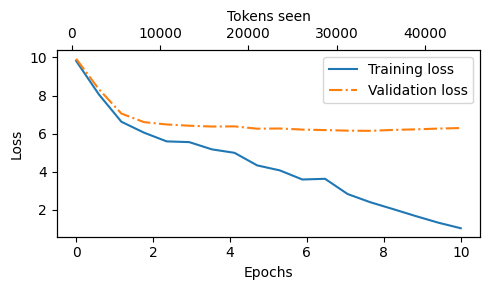

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从上面的结果可以看出，模型开始时生成的是难以理解的字符串，而到了最后，它能够生成大致语法正确的句子。
- 然而，根据训练集和验证集的损失值，我们可以看到模型开始过拟合。
- 如果我们检查模型在最后生成的一些段落，会发现这些段落几乎完全verbatim地包含在训练集中——它只是简单地记住了训练数据。
- 后面，我们将介绍一些解码策略，可以在一定程度上缓解这种记忆问题。
- 请注意，这里的过拟合是因为我们使用了非常小的训练集，并且迭代了很多次。
  - 这里的LLM训练主要用于教育目的；我们主要希望看到模型能够学会生成连贯的文本。
  - 而不是花费数周或数月在昂贵的硬件上训练这个模型，我们稍后会加载预训练权重。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**如果你有兴趣使用更高级的技术来增强这个训练函数，例如学习率预热、余弦退火和梯度裁剪，请参阅 [Appendix D](../../appendix-D/01_main-chapter-code)**

**如果你有兴趣使用更大的训练数据集和更长的训练时间，请参阅 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 解码策略以控制随机性

- 使用相对较小的LLM进行推理（如我们上面训练的GPT模型）相对便宜，因此即使你使用GPU进行训练，也不需要使用GPU进行推理。
- 使用我们之前在简单训练函数中使用的`generate_text_simple`函数（来自上一章），我们可以逐个词（或标记）生成新文本。
- 如第5.1.2节所述，下一个生成的标记是词汇表中概率分数最大的标记。

In [31]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- 即使我们多次执行上面的`generate_text_simple`函数，LLM也将始终生成相同的输出。
- 我们现在介绍两个概念，称为解码策略，来修改`generate_text_simple`：*温度缩放*和*top-k*采样。
- 这些策略将允许模型控制生成文本的随机性和多样性。

### 5.3.1 温度缩放

- 之前，我们总是使用`torch.argmax`采样具有最高概率的标记作为下一个标记。
- 为了增加多样性，我们可以使用`torch.multinomial(probs, num_samples=1)`从概率分布中采样下一个标记。
- 在这里，每个索引被选中的机会对应于输入张量中该索引的概率。

- 这里是一个简要回顾，说明如何生成下一个标记，假设一个非常小的词汇表以供说明。

In [32]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [33]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- 与其通过`torch.argmax`确定最可能的标记，我们使用`torch.multinomial(probas, num_samples=1)`从softmax分布中采样来确定最可能的标记。
- 为了说明目的，让我们看看使用原始softmax概率采样下一个标记1,000次会发生什么：

In [34]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 我们可以通过一个称为温度缩放的概念来控制分布和选择过程。
- “温度缩放”只是一个花哨的词，表示将logits除以一个大于0的数字。
- 温度大于1会在应用softmax后导致标记概率分布更加均匀。
- 温度小于1会在应用softmax后导致标记概率分布更加集中（更尖锐或更峰值）。

- 请注意，生成的dropout输出可能会因操作系统而异；你可以在PyTorch问题跟踪器上查看更多关于这种不一致的信息 [here on the PyTorch issue tracker](https://github.com/pytorch/pytorch/issues/121595)

In [35]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

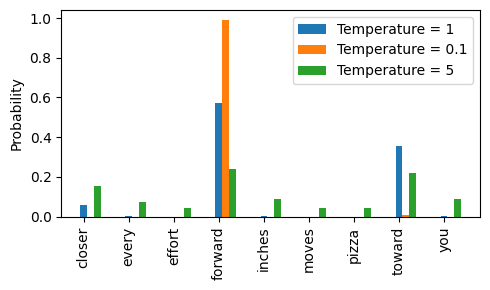

In [36]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到，通过温度0.1进行缩放后，分布变得更加尖锐，接近`torch.argmax`，从而使最可能的单词几乎总是被选中。

In [37]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 通过温度5进行缩放后的概率分布更加均匀。

In [38]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设LLM的输入是“every effort moves you”，使用上述方法有时会生成无意义的文本，例如“every effort moves you pizza”，这种情况有3.2%的概率（1000次中有32次）。

### 5.3.2 Top-k采样


- 为了能够使用更高的温度增加输出的多样性并减少生成无意义句子的概率，我们可以将采样的标记限制在最有可能的top-k个标记中。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- 请注意，该图中的数字已截断为小数点后两位，以减少视觉 clutter。Softmax 行中的值应加总为 1.0。

- 在代码中，我们可以实现如下：


In [39]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [40]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：  
>
>  之前代码单元的一个稍微更高效的实现如下：
>
> ```python
> new_logits = torch.full_like( # create tensor containing -inf values
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor
> ```
> <br>
> 有关更多详细信息，请参阅 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [41]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数


- 上两小节介绍了温度采样和top-k采样。
- 让我们使用这两个概念来修改之前用于通过LLM生成文本的`generate_simple`函数，创建一个新的`generate`函数：

In [42]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [43]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you in began to see it a a little to have been the by his knees


## 5.4 在PyTorch中加载和保存模型权重


- 训练LLM非常计算密集，因此能够保存和加载LLM权重至关重要。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- 在PyTorch中，推荐的方式是通过`torch.save`函数保存模型权重，即所谓的`state_dict`，方法是调用`.state_dict()`方法并传递给`torch.save`函数。

In [44]:
torch.save(model.state_dict(), "model.pth")

- 然后，我们可以将模型权重加载到一个新的`GPTModel`实例中，如下所示：

In [45]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

- 训练LLM时通常使用自适应优化器（如Adam或AdamW），而不是普通的SGD。
- 这些自适应优化器为每个模型权重存储额外的参数，因此如果计划稍后继续预训练，保存这些优化器参数是有意义的。

In [46]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [47]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 从OpenAI加载预训练权重

- 之前，我们仅使用一个非常短的故事书来训练一个小的GPT-2模型，这是为了教学目的。
- 对于感兴趣的读者，可以在[../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)中找到在完整Project Gutenberg图书语料库上的更长的预训练运行。
- 幸运的是，我们不必花费数万到数十万美元来在大型预训练语料库上预训练模型，而是可以加载OpenAI提供的预训练权重。

---

---


⚠️ 注意：某些用户在本节可能会遇到由于TensorFlow兼容性问题而导致的问题，特别是在某些Windows系统上。TensorFlow在这里仅用于加载原始的OpenAI GPT-2权重文件，然后将其转换为PyTorch格式。 如果你遇到与TensorFlow相关的问题，可以使用下面的替代代码，而不是本节中剩余的代码。 此替代方案基于预转换的PyTorch权重，使用与前一节描述的相同转换过程创建。有关详细信息，请参阅以下笔记本：
[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb) notebook.**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码用于从OpenAI下载文件并将权重加载到Python中。
- 由于OpenAI使用了 [TensorFlow](https://www.tensorflow.org/)，我们需要安装并使用TensorFlow来加载权重；[tqdm](https://github.com/tqdm/tqdm)是一个进度条库
- 取消注释并运行下一个单元格以安装所需的库。

In [48]:
# pip install tensorflow tqdm

In [49]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [50]:
# Relative import from the gpt_download.py contained in this folder

from gpt_download import download_and_load_gpt2
# Alternatively:
# from llms_from_scratch.ch05 import download_and_load_gpt2

---

**注意**

- 在极少数情况下，上面的代码单元可能会导致`zsh: illegal hardware instruction python`错误，这可能是由于你机器上TensorFlow安装问题引起的。
- 一位读者发现通过`conda`安装TensorFlow解决了这个问题，具体请参阅 [here](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)
- 你可以在这个辅助 [Python setup tutorial](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)中找到更多安装说明。

---

- 然后，我们可以按照以下方式下载1.24亿参数模型的权重：


In [51]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [52]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [53]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [54]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 另外，"355M"、"774M"和"1558M"也是支持的`model_size`参数。
- 这些不同大小模型之间的差异总结在下图中。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 上面，我们将124M GPT-2模型权重加载到Python中，但仍然需要将其转移到我们的`GPTModel`实例中。
- 首先，我们初始化一个新的`GPTModel`实例。
- 请注意，原始的GPT模型在多头注意力模块中初始化查询、键和值矩阵的线性层时使用了偏置向量，这在我们的情况下不是必需或推荐的；然而，为了能够正确加载权重，我们还需要在实现中启用这些偏置向量，即将`qkv_bias`设置为`True`。
- 我们还使用了原始GPT-2模型使用的`1024`个标记的上下文长度。


In [55]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 接下来的任务是将OpenAI的权重分配给我们`GPTModel`实例中对应的权重张量。


In [56]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [57]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用之前的`generate`函数来生成新的文本。

In [58]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


- 我们知道模型权重加载正确，因为模型能够生成连贯的文本；如果我们有任何小的错误，模型将无法做到这一点。


- 对于从Hugging Face Hub加载权重的替代方法，请参阅 [../02_alternative_weight_loading](../02_alternative_weight_loading)。
- 如果你对GPT架构与Llama架构（由Meta AI开发的一种流行的LLM）进行比较感兴趣，请参阅 [../07_gpt_to_llama](../07_gpt_to_llama) 中的附加内容。


## 摘要和要点


- 请参阅 [./gpt_train.py](./gpt_train.py) 脚本，这是一个独立的训练脚本。
- The [./gpt_generate.py](./gpt_generate.py) 脚本从OpenAI加载预训练权重，并根据提示生成文本。
- 你可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)中找到练习解答。